# Project for DD
--------

   Клиент: Аркадий Новиков  
   Задача: определять, в какой из ресторанов **Novikov Group** пользователь пойдет скорее всего

Для аналитики использовались:
* Jupyter Notebook
* Подсчет простых статистик и предобработка данных в excel 
* Работа с совместными распределениями и отображение географических данных в Tableau

### Первичные гипотезы и анализ

##### Гипотеза 1
Пользователь пойдет в ресторан того же ценового сегмента
1. Пользователи в приниципе очень привязаны к ресторанам одного сегмента
2. Высокие показатели разнообразности разделяют пользователей на определенные соц. дем факторы

Проверяем 1: среди пользователей, посетивших как минимум два ресторана, строим фактор [price var] = [макс сегмент] - [мин сегмент], строим bins  
Проверяем 2: вытаскиваем информацию о пользователях и строим регрессию [price var] ~ пользовательские факторы   


##### Гипотеза 2
Рестораны, в которые ходит пользователь, находятся рядом

1. Рестораны, в которые ходит пользователь находятся рядом между собой (скажем, в пределах 5 км)
2. Сущуствуют группы пользователей, которые ходят в рестораны, находящиеся рядом друг с другом (соц дем)
3. Рестораны, в которые ходит пользователь находятся рядом с домом/на одной станции метро

Проверяем 1: для всех пользователей находим максимальное расстояние между всеми ресторанами, строим график [количество посещенных ресторанов] x [расстояние]  
Проверяем 2: строим регрессию соцдем факторов на расстояние и валидируем  
Проверяем 3 (hard one): определяем для каждого пользователя и ресторана станцию метро и добавляем в предыдущую регрессию


##### Гипотеза 3

Аудитория Прайм пересекается с аудиторией других ресторанов Новикова

1. Среди людей, побывавших в Прайме, гораздо больше тех, кто был в каком-то еще ресторане Novikov Group

Проверяем 1: просто


##### Гипотеза 4 (главная)

По самому пользователю и по тому, в каких ресторанах он был, можно догадаться, куда он пойдет в следующий раз


##### Гипотеза 5 (главная)

Рестораны разбиваются на кластеры по тому, в какие из них ходят пользователи


#### Необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import scipy

import sklearn
from sklearn import manifold
from sklearn import random_projection
from sklearn import cluster

import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns      # For data visualization
import networkx as nx

from IPython.display import display

%matplotlib notebook

#### Загружаем базовые данные
Все excel файлы загружены "as-is", за исключением:
1. Для ресторанов добавлена информация о геокодировании (файл geocode.py)
2. ID_SN разделена на VK и Facebook (так называемая первая нормальная форма представления)

In [2]:
ab_data = pd.read_excel('../data/A-B ID_rest vs Rest_attributes.xlsx', header=0)
ac_data = pd.read_excel('../data/A-C ID_rest vs ID_Afisha_user.xlsx', header=0)
cd_data = pd.read_excel('../data/C-D ID_Afisha_user vs ID_SN.xlsx', header=0)
fg_data = pd.read_excel('../data/F_G VK_Group_ID vs Group_attributes.xlsx', header=0)

In [3]:
de_data = pd.read_excel('../data/D-E ID_VK vs VK_attributes.xlsx', header=0)
df_data = pd.read_excel('../data/D-F ID_VK vs VK_Group_ID.xlsx', header=0)

In [4]:
# Get rid of empty and service columns
# de
keys_to_drop = [key for key in de_data.keys() if 'Unnamed' in key]
de_data = de_data.drop(keys_to_drop, axis=1)

# df
df_data = df_data.drop(df_data.columns[[3, 4, 5, 6, 7, 8, 9, 10]], axis=1)


In [5]:
# Fix ID_Rest for ac_data
# Convert it into ID_rest by cutting url path
ac_data['ID_rest'] = ac_data.ID_Rest.map(lambda x: '/' + '/'.join(x.split('/')[3:]))
ac_data = ac_data.drop(ac_data.ID_Rest.name, axis=1)

In [6]:
# Clean up nan
ac_data = ac_data.dropna(axis=0)

#### Разбираемся с тем, что за данные у нас есть

In [7]:
display(ab_data.head(5))

display(ac_data.head(5))

display(cd_data.head(5))

display(de_data.head(5))
display(de_data.info())
print(', '.join(de_data.keys()))

display(df_data.head(5))
display(df_data.info())

display(fg_data.head(5))
display(fg_data.info())

,ID_rest,Rest_name,Cuisine,Price,Tags,Address,Longitude,Latitude,Novikov,Italy,Asia,American
0,/msk/restaurant/15958/,Beermarket,Пивные рестораны,700–1500 рублей,"Немецкая кухня,Бургеры,Стейки,Европейская кухн...","Москва, Бутырская, 69",37.582610,55.802497,0,0.0,0.0,1.0
1,/msk/restaurant/218258/,Grammy's,Караоке,1500–2500 рублей,"Европейская кухня,Бары,Караоке","Москва, Кутузовский просп., 2/1, стр. 6, в Кон...",37.566862,55.752318,0,0.0,0.0,0.0
2,/msk/restaurant/19998/,Via Романо,Итальянская кухня,1500–2500 рублей,"Итальянская кухня,Пицца,Паста,Европейская кухня","Москва, Лавочкина, 34",37.493919,55.856295,0,1.0,0.0,0.0
3,/msk/restaurant/75769/,Lao Lee Café,Вьетнамская кухня,До 700 рублей,"Вьетнамская кухня,Вок,Кафе,Стритфуд,Лучшие рес...","Москва, Миусская пл., 9, стр. 11",37.596489,55.778654,0,0.0,1.0,0.0
4,/msk/restaurant/42248/,Double B,Кофейни,До 700 рублей,"Кофейни,Лучшие рестораны в Москве,Где пить кофе","Москва, Милютинский пер., 3",37.631469,55.761573,0,0.0,0.0,0.0


,ID_Afisha_user,ID_rest
0,www.afisha.ru/personalpage/3008125,/msk/restaurant/15958/
1,www.afisha.ru/personalpage/2993572,/msk/restaurant/15958/
2,www.afisha.ru/personalpage/2627134,/msk/restaurant/15958/
3,www.afisha.ru/personalpage/2560943,/msk/restaurant/15958/
4,www.afisha.ru/personalpage/3034211,/msk/restaurant/218258/


,ID_Afisha_user,ID_VK,ID_FB
0,www.afisha.ru/personalpage/2627134,0,http://facebook.com/1075523789126704
1,www.afisha.ru/personalpage/1425368,0,http://facebook.com/698204806958139
2,www.afisha.ru/personalpage/2696251,http://vk.com/id16546298,http://facebook.com/657938597698741
3,www.afisha.ru/personalpage/1337727,0,http://facebook.com/759006417567778
4,www.afisha.ru/personalpage/1024043,0,http://facebook.com/723866285


,ID,NDA01,NDA02,NDA03,NDA04,NDA05,NDA06,NDA07,NDA08,NDA09,...,INTEREST_tourism,INTEREST_travel,INTEREST_TV,INTEREST_ukraine,INTEREST_video,INTEREST_way_of_life,INTEREST_wedding_communities,INTEREST_women_communities,INTEREST_workout,INTEREST_youth_communities
0,10026122@VK,0,0,1,0,0,0,0,30,27,...,0,0,0.0104167,0,0,0.00520833,0,0.078125,0.00520833,0
1,39124462@VK,0,0,1,0,0,0,0,62,154,...,0.00769231,0.00769231,0.00769231,0,0.00769231,0.00769231,0,0.0153846,0,0.0384615
2,13478168@VK,0,0,1,0,0,0,0,47,108,...,0,0,0,0.00854701,0.00854701,0.025641,0,0.042735,0.00854701,0.00854701
3,1020642@VK,0,0,1,0,1,0,0,107,76,...,0,0,0.00826446,0,0,0.00826446,0,0.00826446,0,0
4,2414374@VK,0,0,1,0,0,0,0,31,-,...,0,0,0,0,0,0,0,0.0606061,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4290 entries, 0 to 4289
Columns: 140 entries, ID to INTEREST_youth_communities
dtypes: object(140)
memory usage: 4.6+ MB


None

ID, NDA01, NDA02, NDA03, NDA04, NDA05, NDA06, NDA07, NDA08, NDA09, NDA10, NDA11, NDA12, NDA13, ActivityIndex, AverageFriendsAge, AverageFriendsRegMonthDelta, EducationType, FriendsAverageDeletedAccounts, FriendsAverageHasHighSchools, FriendsAverageHasJobs, FriendsPerDay, LifeTime, RegDate, MobileUsageAll, MobileUsageAndroid, MobileUsageIPad, MobileUsageIphone, MobileUsageWinPhone, MonthsFromRegDate, NumberOfAdvancedSchools, NumberOfChildren, NumberOfCompanies, NumberOfDeletedFriends, NumberOfFollowers, NumberOfFriends, NumberOfHighSchools, NumberOfRelatives, NumberOfSchools, Relation, UseScreenName, YearsSinceRegDate, INTEREST_acquaint_communic, INTEREST_acquaintances, INTEREST_active_rest, INTEREST_ad, INTEREST_animals, INTEREST_anime_hentai, INTEREST_architecture, INTEREST_art_design, INTEREST_beautiful_girls, INTEREST_beauty, INTEREST_books, INTEREST_business, INTEREST_cars, INTEREST_cartoons, INTEREST_caucasian, INTEREST_celebrities, INTEREST_children, INTEREST_cognitive, INTEREST_

,ID_VK,Group_ID,Сколько VK_ID из колонки A состоят в данной группе
0,42422921@VK,42025607@gVK,55
1,42422921@VK,78878985@gVK,1
2,42422921@VK,11433871@gVK,1
3,42422921@VK,62241785@gVK,14
4,42422921@VK,37631861@gVK,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566922 entries, 0 to 566921
Data columns (total 3 columns):
ID_VK                                                 566922 non-null object
Group_ID                                              566922 non-null object
Сколько VK_ID из колонки A состоят в данной группе    566922 non-null int64
dtypes: int64(1), object(2)
memory usage: 13.0+ MB


None

,Group,Number of VK_ID from Afisha in this group,Category,Subcategory,Group Name,Group Description,Subscribers,Coverage,Visitors
0,24098496@gVK,744,Наука и образование,Познавательно,Esquire,Cообщество любителей журнала Esquire.,2496135.0,667239.0,26518.0
1,29302425@gVK,691,"СМИ, реклама и PR",Реклама,Шедевры рекламы,Лучшее из мира рекламы,2568350.0,702029.0,37213.0
2,30022666@gVK,618,Юмор,Юмор,Лепра,Ле́пра (Проказа) — хроническое инфекционное за...,3695212.0,1358982.0,174315.0
3,32194285@gVK,611,Женские сообщества.Мужские сообщества,Кулинария,Bon Appétit | Лучшие рецепты,Самые вкусные блюда и напитки со всего света!,4504162.0,952341.0,26279.0
4,37119411@gVK,573,Региональные сообщества,Россия.Региональные сообщества,KudaGo: Москва,Афиша Москвы. Самые интересные места и события...,1023639.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222148 entries, 0 to 222147
Data columns (total 9 columns):
Group                                        222148 non-null object
Number of VK_ID from Afisha in this group    222148 non-null int64
Category                                     82946 non-null object
Subcategory                                  82946 non-null object
Group Name                                   88919 non-null object
Group Description                            71178 non-null object
Subscribers                                  88946 non-null float64
Coverage                                     18835 non-null float64
Visitors                                     18835 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 15.3+ MB


None

Список вегетерианских групп: пригодится для эксперимента с вегетарианцами

In [8]:
display(fg_data.loc[lambda fg_data: fg_data['Group Name'] == 'Первый Вегетарианский', :])
display(fg_data.loc[lambda fg_data: fg_data['Group Name'] == 'Я ВЕГЕТАРИАНЕЦ', :])
display(fg_data.loc[lambda fg_data: fg_data['Group Name'] == 'Веганский нежданчик', :])
display(fg_data.loc[lambda fg_data: fg_data['Group Name'] == 'Funny Slim • Диетические Рецепты • Веган • Диеты', :])
display(fg_data.loc[lambda fg_data: fg_data['Group Name'] == 'FRESH & FRESH. Сыроедение, веганство', :])
display(fg_data.loc[lambda fg_data: fg_data['Group Name'] == 'Вегетарианцы / Веганы', :])

# ab_nov_data = ab_data.loc[lambda ab_data: ab_data.Novikov == 1, :]

,Group,Number of VK_ID from Afisha in this group,Category,Subcategory,Group Name,Group Description,Subscribers,Coverage,Visitors
380,58656979@gVK,98,Женские сообщества.Мужские сообщества,Кулинария,Первый Вегетарианский,Мы размещаем информацию для всех типов вегетар...,393392.0,81858.0,3170.0


,Group,Number of VK_ID from Afisha in this group,Category,Subcategory,Group Name,Group Description,Subscribers,Coverage,Visitors
2844,23505064@gVK,21,Женские сообщества,Диеты,Я ВЕГЕТАРИАНЕЦ,"Это не диета и не модное течение, это целый об...",100465.0,5214.0,747.0


,Group,Number of VK_ID from Afisha in this group,Category,Subcategory,Group Name,Group Description,Subscribers,Coverage,Visitors
1800,26360753@gVK,31,Женские сообщества.Мужские сообщества,Кулинария,Веганский нежданчик,"Специально для тех, кто хочет разнообразить св...",106647.0,NaN,NaN


,Group,Number of VK_ID from Afisha in this group,Category,Subcategory,Group Name,Group Description,Subscribers,Coverage,Visitors
9174,44153073@gVK,8,"Искусство, дизайн",Дизайн.Интерьер,Funny Slim • Диетические Рецепты • Веган • Диеты,NaN,213306.0,30416.0,860.0


,Group,Number of VK_ID from Afisha in this group,Category,Subcategory,Group Name,Group Description,Subscribers,Coverage,Visitors
3341,33336025@gVK,18,Философия и эзотерика,Образ жизни,"FRESH & FRESH. Сыроедение, веганство",Если вы интересуетесь здоровьем и саморазвитие...,129308.0,18253.0,1037.0


,Group,Number of VK_ID from Afisha in this group,Category,Subcategory,Group Name,Group Description,Subscribers,Coverage,Visitors
2424,17228@gVK,24,Женские сообщества.Мужские сообщества,Кулинария.Образ жизни,Вегетарианцы / Веганы,Добро пожаловать в самое многочисленное русско...,69501.0,NaN,NaN


Сколько ресторанов посетили пользователи, гистограмма

In [9]:
num = []
for u, rests in ac_data.groupby(by='ID_Afisha_user').groups.items():
    num.append(len(rests))

In [10]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xlim=10)
sns.distplot([i for i in num if i > 1], kde=0, norm_hist=0, hist=True, ax=ax, bins=1000)

<IPython.core.display.Javascript object>

График "Сколько ресторанов посетил-сколько из них ресторанов Новикова"

In [11]:
points_novikov = []
points_total = []
abc_data = pd.merge(left=ac_data, right=ab_data, left_on='ID_rest', right_on='ID_rest', how='inner')
for u, rests in abc_data.groupby(by='ID_Afisha_user').groups.items():
    novikov, total = 0, 0
    for r in rests:
        if abc_data.Novikov[r] == 1:
            novikov += 1
        total += 1
    if novikov >= 2:
        print(u, novikov)
    points_novikov.append(novikov)
    points_total.append(total)

www.afisha.ru/personalpage/2663289 2
www.afisha.ru/personalpage/2099805 2
www.afisha.ru/personalpage/142312 2
www.afisha.ru/personalpage/1734956 2
www.afisha.ru/personalpage/1022984 2
www.afisha.ru/personalpage/1237081 5
www.afisha.ru/personalpage/2492509 2
www.afisha.ru/personalpage/2652019 2
www.afisha.ru/personalpage/172507 2
www.afisha.ru/personalpage/2274507 4


Эксперимент с анализом того, куда ходят "спортсмены"

In [12]:
from collections import Counter

counter = Counter()

for u, rests in abc_data.groupby(by='ID_Afisha_user').groups.items():
    novikov, total = 0, 0
    # Retrieve vk_id
    try:
        vk_id = cd_data.loc[cd_data.ID_Afisha_user == u, :].as_matrix()[0][1]
    except:
        vk_id = 0
    if vk_id == 0:
        continue
    
    # Form valid identifier
    vk_id = vk_id.split('/')[-1][2:] + '@VK'
    veg = False

    try:
        res = de_data.loc[de_data.ID == vk_id, ['INTEREST_fitness', 'INTEREST_sport_and_health']].as_matrix()
        fitness = res[0][0]
        sport = res[0][1]
    except:
        fitness = 0
        sport = 0
    
    if isinstance(fitness, str) or isinstance(sport, str):
        continue
    ok = fitness > 0 and sport > 0
    
    if not ok:
        continue
        
    for r in rests:
        if abc_data.Novikov[r] == 1:
            novikov += 1
            counter[abc_data.Rest_name[r]] += 1
        total += 1
        
display(counter)

Counter({' Фарш': 1,
         'Brisket BBQ': 2,
         'China Club': 1,
         'Fumisawa Sushi': 2,
         'Mr. Lee': 1,
         'Prime': 4,
         'Valenok': 3,
         'Барашка': 3,
         'Белое солнце пустыни': 1,
         'Маркет': 1,
         'Рыбы нет': 1,
         'Сыроварня': 1,
         'Чердак': 1})

In [13]:
display(abc_data)

,ID_Afisha_user,ID_rest,Rest_name,Cuisine,Price,Tags,Address,Longitude,Latitude,Novikov,Italy,Asia,American
0,www.afisha.ru/personalpage/3008125,/msk/restaurant/15958/,Beermarket,Пивные рестораны,700–1500 рублей,"Немецкая кухня,Бургеры,Стейки,Европейская кухн...","Москва, Бутырская, 69",37.582610,55.802497,0,0.0,0.0,1.0
1,www.afisha.ru/personalpage/2993572,/msk/restaurant/15958/,Beermarket,Пивные рестораны,700–1500 рублей,"Немецкая кухня,Бургеры,Стейки,Европейская кухн...","Москва, Бутырская, 69",37.582610,55.802497,0,0.0,0.0,1.0
2,www.afisha.ru/personalpage/2627134,/msk/restaurant/15958/,Beermarket,Пивные рестораны,700–1500 рублей,"Немецкая кухня,Бургеры,Стейки,Европейская кухн...","Москва, Бутырская, 69",37.582610,55.802497,0,0.0,0.0,1.0
3,www.afisha.ru/personalpage/2560943,/msk/restaurant/15958/,Beermarket,Пивные рестораны,700–1500 рублей,"Немецкая кухня,Бургеры,Стейки,Европейская кухн...","Москва, Бутырская, 69",37.582610,55.802497,0,0.0,0.0,1.0
4,www.afisha.ru/personalpage/3034211,/msk/restaurant/218258/,Grammy's,Караоке,1500–2500 рублей,"Европейская кухня,Бары,Караоке","Москва, Кутузовский просп., 2/1, стр. 6, в Кон...",37.566862,55.752318,0,0.0,0.0,0.0
5,www.afisha.ru/personalpage/1425368,/msk/restaurant/218258/,Grammy's,Караоке,1500–2500 рублей,"Европейская кухня,Бары,Караоке","Москва, Кутузовский просп., 2/1, стр. 6, в Кон...",37.566862,55.752318,0,0.0,0.0,0.0
6,www.afisha.ru/personalpage/1588067,/msk/restaurant/218258/,Grammy's,Караоке,1500–2500 рублей,"Европейская кухня,Бары,Караоке","Москва, Кутузовский просп., 2/1, стр. 6, в Кон...",37.566862,55.752318,0,0.0,0.0,0.0
7,www.afisha.ru/personalpage/2859031,/msk/restaurant/19998/,Via Романо,Итальянская кухня,1500–2500 рублей,"Итальянская кухня,Пицца,Паста,Европейская кухня","Москва, Лавочкина, 34",37.493919,55.856295,0,1.0,0.0,0.0
8,www.afisha.ru/personalpage/2765266,/msk/restaurant/19998/,Via Романо,Итальянская кухня,1500–2500 рублей,"Итальянская кухня,Пицца,Паста,Европейская кухня","Москва, Лавочкина, 34",37.493919,55.856295,0,1.0,0.0,0.0
9,www.afisha.ru/personalpage/2896540,/msk/restaurant/19998/,Via Романо,Итальянская кухня,1500–2500 рублей,"Итальянская кухня,Пицца,Паста,Европейская кухня","Москва, Лавочкина, 34",37.493919,55.856295,0,1.0,0.0,0.0


##### Задача 1

Кластеризация ресторанов Novikov Group

Создаем связи — ребро между ресторанами существует, если есть пользователь, который был в двух ресторанах (или хотя бы заинтересован в этом)

In [14]:
# Got Novikov group restaurants

ab_nov_data = ab_data.loc[lambda ab_data: ab_data.Novikov == 1, :]
nov_rests = {}

for row in ab_nov_data.itertuples():
    if row.Rest_name in nov_rests:
        nov_rests[row.Rest_name].append(row.Index)
    else:
        nov_rests[row.Rest_name] = [row.ID_rest]
        
nov_rests.keys()

dict_keys(['Чайковский в Тифлисе', 'Chips', 'Tatler', 'Кавказская пленница', 'Куршевель', ' Фарш', 'Маркет', 'Узбекистан', 'Семирамис', 'Krispy Kreme', 'Фарш', 'Zoo Beer & Grill', 'Yoko', 'White Café', 'Roni', 'Mr. Lee', 'Камчатка', 'Донна Маргарита', 'Brisket BBQ', 'Аист', 'Чердак', 'Shore House', 'China Club', 'Белое солнце пустыни', 'Страна, которой нет', 'Сыр', 'Большой', 'Высота 5642', 'Francesco', 'Luce', 'Novikov', 'Vogue', 'Барашка', 'Царская охота', 'Сирена', 'Веранда у дачи', ' Cantinetta Antinori', 'Fumisawa Sushi', 'Рыбы нет', 'Чайковский', 'Prime', 'Ваниль', 'Недальний Восток', 'Valenok', 'Сыроварня', 'Водный'])

In [15]:
# Iterate over users and add link between two restaurnts, if some user was in both places

nov_rests_keys = list(nov_rests.keys())
nov_rests_idx = {nov_rests_keys[i]: i for i in range(len(nov_rests_keys))}
nov_rests_dists = np.zeros((len(nov_rests_keys), len(nov_rests_keys)), dtype=np.float64)

total = 0

for u, rests in abc_data.groupby(by='ID_Afisha_user').groups.items():
    for r1 in rests:
        if abc_data.Novikov[r1] != 1:
            continue
            
        for r2 in rests:
            if abc_data.Novikov[r2] != 1:
                continue
            if abc_data.Rest_name[r1] == abc_data.Rest_name[r2]:
                continue
                
            i1 = nov_rests_idx[abc_data.Rest_name[r1]]
            i2 = nov_rests_idx[abc_data.Rest_name[r2]]
            nov_rests_dists[i1, i2] += 1
            total += 1
            
display(total)        
nov_rests_dists_sps = scipy.sparse.csc_matrix(nov_rests_dists)
for i, j in zip(nov_rests_dists.nonzero()[0], nov_rests_dists.nonzero()[1]):
    if i < j:
        print(nov_rests_keys[i], nov_rests_keys[j])

48

Куршевель White Café
Куршевель Большой
Куршевель Francesco
Куршевель Недальний Восток
Маркет Valenok
Семирамис Недальний Восток
Семирамис Valenok
White Café Большой
White Café Francesco
White Café Недальний Восток
Roni Prime
Mr. Lee Чердак
Mr. Lee China Club
Mr. Lee Сыр
Mr. Lee Fumisawa Sushi
China Club Сыр
China Club Сирена
China Club Fumisawa Sushi
Сыр Fumisawa Sushi
Большой Francesco
Большой Недальний Восток
Francesco Недальний Восток
Fumisawa Sushi Valenok


Функция для рисования точек с подписями на графике
В дальнейшем не сильно помогла

In [16]:
import random
def plot_embedding(X, y, names, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    x_max += (x_max - x_min) * 0.1
    x_min -= (x_max - x_min) * 0.1
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0] + (random.random() - 0.5) * 0.1, X[i, 1] + (random.random() - 0.5) * 0.1, names[i] + ' ' + str(y[i]), # str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 5.),
                 fontdict={'weight': 'bold', 'size': 9})
        
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [17]:
# Convert pairwise matrix into distance matrix
X = nov_rests_dists + 0.0001 * np.ones(nov_rests_dists.shape) + 100000000 * np.eye(nov_rests_dists.shape[0])
X = 1 / X
y = range(X.shape[0])

# Use one of standard algorithms for embedding — place points into plane to see mutual interrelations
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=1000)
X_mds = clf.fit_transform(X)

plot_embedding(X_mds, y, nov_rests_keys, "MDS embedding of the Novikov Group restaurants")

Computing MDS embedding


/Users/vlkulpinov/anaconda3/lib/python3.5/site-packages/sklearn/manifold/mds.py:396: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


<IPython.core.display.Javascript object>

Как видим, количество посетителей, которые зарегистрированы на Афише и сходили сразу в несколько ресторанов Новикова очень мало для того, чтобы сделать какие либо вывод

Попробуем запустить алгоритм Manifold Learning для всего пространства

In [18]:
nov_rests2 = {}

for row in ab_data.itertuples():
    if not isinstance(row.ID_rest, str) or not 'msk' in row.ID_rest:
        continue
    if row.Rest_name in nov_rests2:
        nov_rests2[row.Rest_name].append(row.Index)
    else:
        nov_rests2[row.Rest_name] = [row.ID_rest]
        
nov_rests2.keys()


nov_rests_keys2 = list(nov_rests2.keys())
nov_rests_idx2 = {nov_rests_keys2[i]: i for i in range(len(nov_rests_keys2))}
nov_rests_dists2 = np.zeros((len(nov_rests_keys2), len(nov_rests_keys2)), dtype=np.float64)

total = 0

for u, rests in abc_data.groupby(by='ID_Afisha_user').groups.items():
    for r1 in rests:    
        for r2 in rests:
            if abc_data.Rest_name[r1] == abc_data.Rest_name[r2]:
                continue
            if abc_data.Rest_name[r1] in nov_rests_idx2 and abc_data.Rest_name[r2] in nov_rests_idx2:
                i1 = nov_rests_idx2[abc_data.Rest_name[r1]]
                i2 = nov_rests_idx2[abc_data.Rest_name[r2]]
                nov_rests_dists2[i1, i2] += 1
                total += 1
            
display(total)
display(nov_rests_dists2.shape)
nov_rests_dists_sps2 = scipy.sparse.csc_matrix(nov_rests_dists2)

20076

(4725, 4725)

In [19]:
# Delete that non-novikov restaurants, that have no cross reviews
to_del = []
for i in range(nov_rests_dists2.shape[0]):
    zer = True
    if nov_rests_keys2[i] in nov_rests:
        continue
    for j in range(nov_rests_dists2.shape[1]):
        if nov_rests_dists2[i, j] != 0:
            zer = False
            break
    if zer:
        to_del.append(i)

display(len(to_del))
display(nov_rests_dists2.shape[0])

3210

4725

In [20]:
nov_rests_dists3 = np.delete(np.delete(nov_rests_dists2, to_del, axis=0), to_del, axis=1)
nov_rests_keys3 = np.delete(nov_rests_keys2, to_del, axis=0)

print(nov_rests_dists3.shape)
print(nov_rests_keys3.shape)

(1515, 1515)
(1515,)


In [21]:
# Again — manifold
X = nov_rests_dists3 + 0.0001 * np.ones(nov_rests_dists3.shape) + 100000000 * np.eye(nov_rests_dists3.shape[0])
X = 1 / X
y = range(X.shape[0])
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=1000)
X_mds = clf.fit_transform(X)

plot_embedding(X_mds, y, nov_rests_keys3, "MDS embedding of the Novikov Group restaurants")

Computing MDS embedding


/Users/vlkulpinov/anaconda3/lib/python3.5/site-packages/sklearn/manifold/mds.py:396: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


<IPython.core.display.Javascript object>

Сохраняем метки о среднем чеке для отображения на графике

In [23]:
y = list(range(X_mds.shape[0]))
for i in range(len(nov_rests_keys)):
    try:
        t = abc_data.loc[abc_data.Rest_name == nov_rests_keys4[i], :].as_matrix()[0][4]
    except:
        t = 0
    if t == 'Больше 2500 рублей':
        y[i] = 3
    elif t == '1500–2500 рублей':
        y[i] = 2
    elif t == '700–1500 рублей':
        y[i] = 1
    else:
        y[i]= 0

# plot_embedding(X_mds2, y, nov_rests_keys4, "MDS embedding of the Novikov Group restaurants")

Неудачные эксперименты с кластеризацией

In [24]:
# # Now just clustering
# clst = cluster.AgglomerativeClustering(n_clusters=4)
# y_clst = clst.fit_predict(X)

# # nov_rests_dists4 = np.delete(np.delete(nov_rests_dists3, to_del, axis=0), to_del, axis=1)
# y_clst2 = np.delete(y_clst, to_del, axis=0)
# # nov_rests_keys4 = np.delete(nov_rests_keys3, to_del, axis=0)

# for val in range(clst.n_clusters):
#     r = []
#     for i in range(len(y_clst2)):
#         if y_clst[i] != val:
#             continue
#         r.append(nov_rests_keys[i])
        
#     print(val, ':', ', '.join(r))

In [25]:
y = list(range(len(nov_rests_keys)))
for i in range(len(nov_rests_keys)):
    try:
        t = abc_data.loc[abc_data.Rest_name == nov_rests_keys[i], :].as_matrix()[0][4]
    except:
        t = 0
    if nov_rests_keys[i] == 'Tatler' or nov_rests_keys[i] == 'Узбекистан':
        t = 'Больше 2500 рублей'
    if t == 'Больше 2500 рублей':
        y[i] = 3
    elif t == '1500–2500 рублей':
        y[i] = 2
    elif t == '700–1500 рублей':
        y[i] = 1
    else:
        y[i]= 0

In [26]:
print(nov_rests_dists.shape)
print(len(nov_rests_keys))

(46, 46)
46


Эксперимент с отображением данных в виде графа

<IPython.core.display.Javascript object>


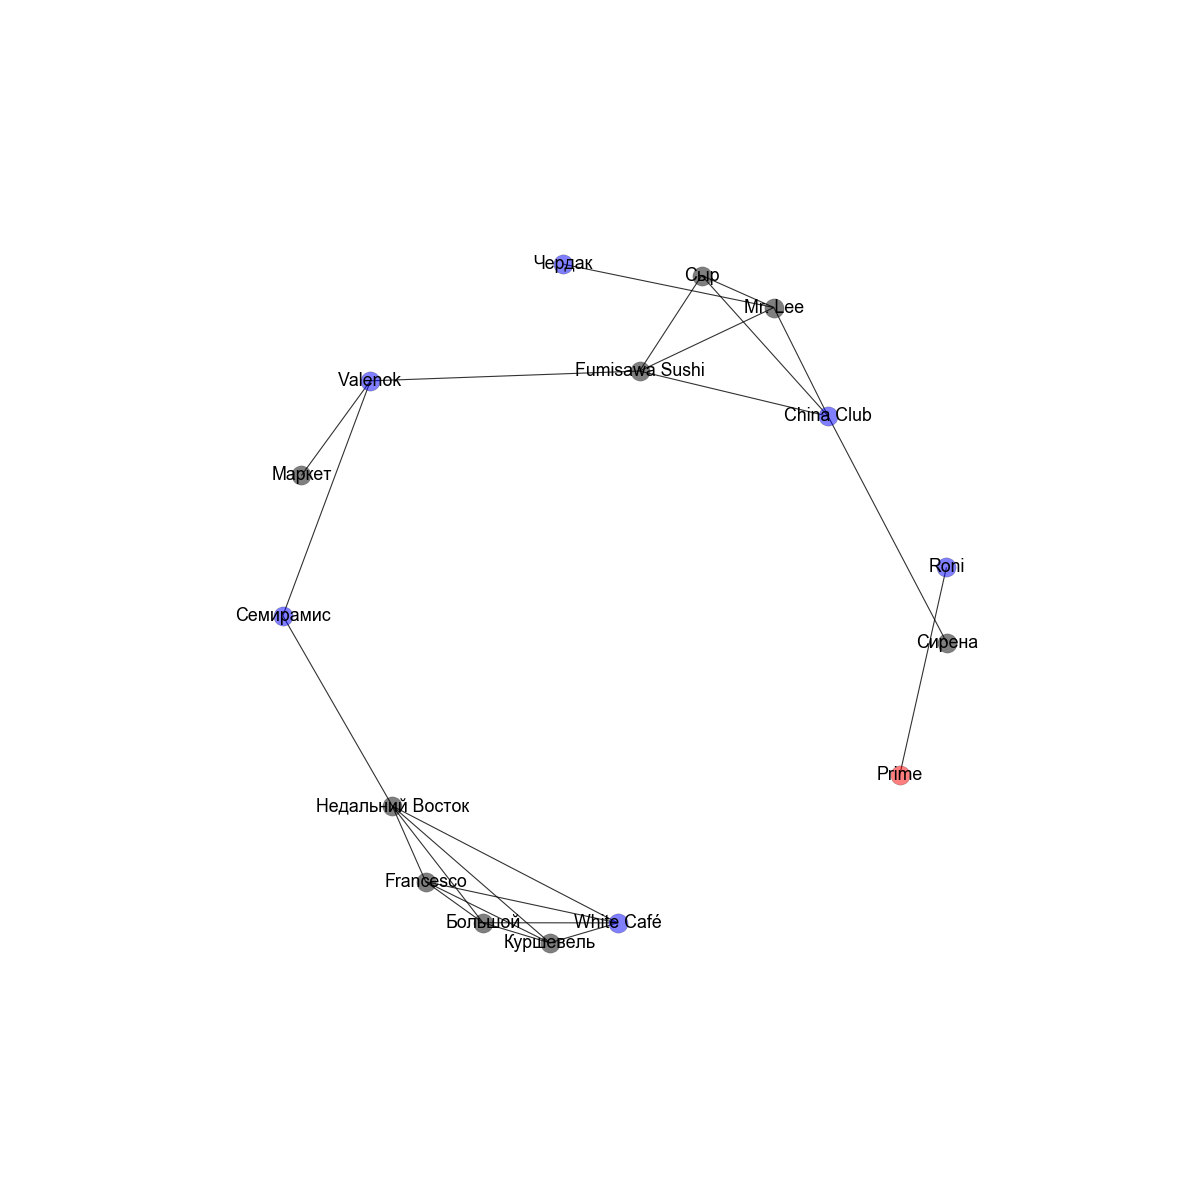

In [27]:
G = nx.Graph()
plt.figure(figsize=(15,15))
plt.axis('off')

for i in range(nov_rests_dists.shape[0]):
    for j in range(nov_rests_dists.shape[1]):
        if nov_rests_dists[i, j] > 0:
            G.add_edge(nov_rests_keys[i], nov_rests_keys[j], weight=nov_rests_dists[i, j])

pos=nx.spring_layout(G, scale=5)
colors = {0: 'r', 1: 'g', 2: 'b', 3: 'k'}
for t in range(4):
    nodelist = [nov_rests_keys[i] for i in range(len(nov_rests_keys)) if t == y[i] and nov_rests_keys[i] in G.nodes()]
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colors[t], alpha=0.5)

nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='k', alpha=0.8, width=1)
nx.draw_networkx_labels(G, pos, font_size=16, font_family='sans-serif')

plt.show() # display
plt.savefig("afisha_1.png")

#### Данные вконтакте
Идея с анализом пользователей по совместным связям показалось интересной, но данных для анализа немного.  

Для тестирования гипотезы требовалось скачать данные по отзывам о ресторанах и сравнить, какие связи существуют.  
К счастью, API VK имеет метод `newsfeed.search`, который позволяет получать информацию о записях людей, содержащих:
* Геопозицию
* Определенные слова

В итоге мы прошлись по первым 200 записям за каждый из дней (последние 90 дней) и скачали записи людей, которые так же имели геопозицию, совпадающую с рестораном. Отзыв так же должен содержать ключевые слова ("вкусно", "ресторан") или быть очень коротким (зачастую это emoji с едой) чтобы быть классифицированным как отзыв о ресторане.

При запуске метода с токеном можно получить гораздо больше информации, однако это не было сделано по причине нехватки времени (доставались только user_id, имя и пол пользователя)

Файл для скачивания get_restaurants.py

In [28]:
vk_users = pd.read_csv('../../core/miners/test.csv', header=0)

In [29]:
vk_users.head(5)

,Rest_id,VK_ID,VK_sex
0,/msk/restaurant/32591/,6333959,1
1,/msk/restaurant/32591/,207211768,1
2,/msk/restaurant/32591/,3514236,1
3,/msk/restaurant/32591/,147333374,1
4,/msk/restaurant/32591/,2238413,1


Проверяем, что пользователей, побывавших в нескольких ресторанах достаточно много

<IPython.core.display.Javascript object>


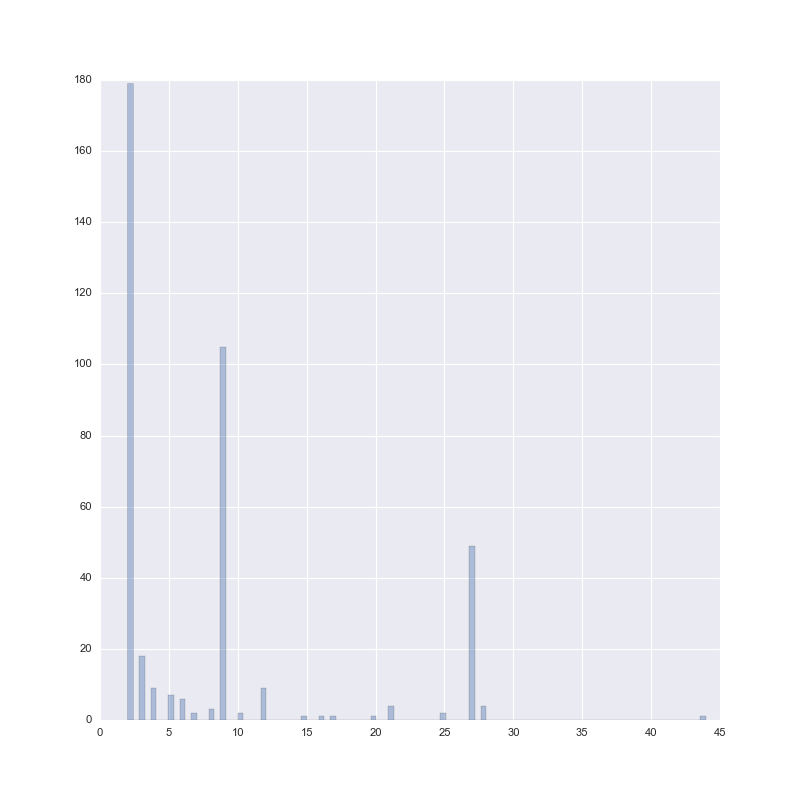

In [30]:
u = {}
for record in vk_users.itertuples():
    if record.VK_ID in u:
        u[record.VK_ID].append(record.Rest_id)
    else:
        u[record.VK_ID] = [record.Rest_id]   
# display(u) 
bins = []
for i, j in u.items():
    bins.append(len(set(j)))
    # print(j)
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot([i for i in bins if i > 1], kde=0, norm_hist=0, hist=True, ax=ax, bins=100)

In [31]:
# For every Rest_id got its name
# After merge it

vka_data = pd.merge(left=ab_data, right=vk_users, left_on='ID_rest', right_on='Rest_id', how='inner')
display(vka_data)

# abc_data.loc[abc_data.Rest_name == nov_rests_keys[i], :].as_matrix()[0][4]

,ID_rest,Rest_name,Cuisine,Price,Tags,Address,Longitude,Latitude,Novikov,Italy,Asia,American,Rest_id,VK_ID,VK_sex
0,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,6333959,1
1,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,207211768,1
2,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,3514236,1
3,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,147333374,1
4,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,2238413,1
5,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,64578161,1
6,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,70408139,1
7,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,13664963,1
8,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,50298601,2
9,/msk/restaurant/32591/,Чайковский,Кафе,1500–2500 рублей,"Итальянская кухня,Русская кухня,Хинкали,Хачапу...","Москва, Триумфальная пл., 4/31, в здании Конце...",37.596220,55.768829,1,1.0,0.0,1.0,/msk/restaurant/32591/,3066871,1


То же самое, только для названий, а не Rest_id. Фильтруем людей в завиимости от пола, для получение данных отдельно для мужчин, отдельно для женщин

<IPython.core.display.Javascript object>


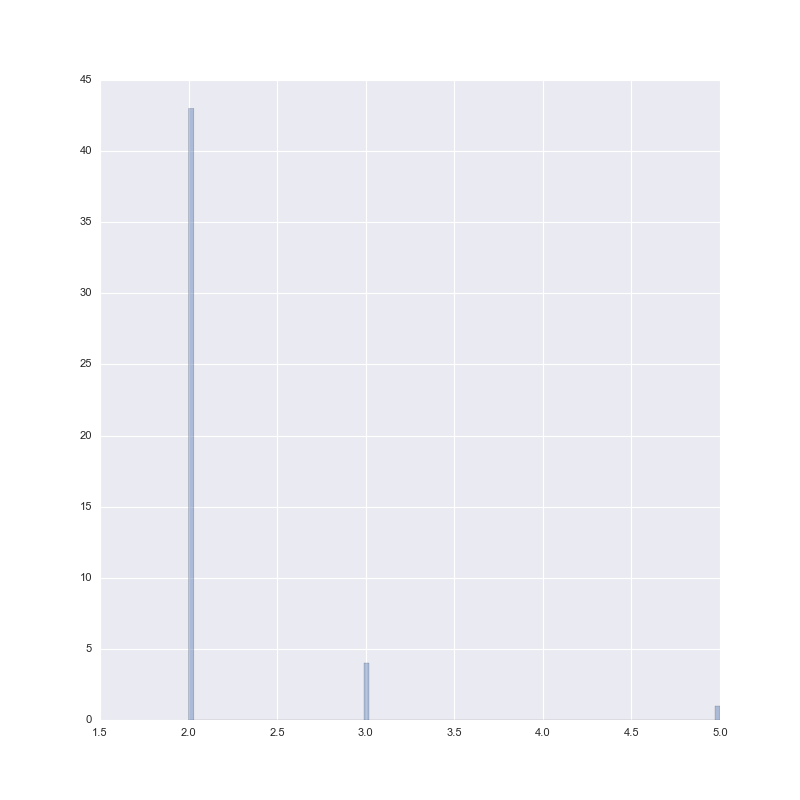

In [32]:
user_rest = {}
for record in vka_data.itertuples():
    if record.VK_sex != 2:
        continue
    if not record.VK_ID in user_rest:
        user_rest[record.VK_ID] = set()
    user_rest[record.VK_ID].add(record.Rest_name)
    
bins = []
for i, j in user_rest.items():
    bins.append(len(set(j)))
    # print(j)
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot([i for i in bins if i > 1], kde=0, norm_hist=0, hist=True, ax=ax, bins=100)

Заполняем таблицу смежности

In [33]:

nov_rests_dists_vk = np.zeros((len(nov_rests_keys), len(nov_rests_keys)), dtype=np.float64)

for u, rests in user_rest.items():
    for r1 in rests:
            
        for r2 in rests:
            if r1 == r2:
                continue
                
            i1 = nov_rests_idx[r1]
            i2 = nov_rests_idx[r2]
            nov_rests_dists_vk[i1, i2] += 1
            total += 1
            
for i, j in zip(nov_rests_dists_vk.nonzero()[0], nov_rests_dists_vk.nonzero()[1]):
    if i < j:
        print(nov_rests_keys[i], nov_rests_keys[j])

Chips  Фарш
Chips Фарш
Tatler Novikov
 Фарш Фарш
 Фарш Novikov
Маркет Novikov
Узбекистан Донна Маргарита
Узбекистан Белое солнце пустыни
Узбекистан Сирена
Узбекистан Веранда у дачи
Узбекистан Рыбы нет
Krispy Kreme Ваниль
Фарш Страна, которой нет
Фарш Сыр
Фарш Большой
Фарш Novikov
Фарш Сирена
Фарш Рыбы нет
Фарш Valenok
Zoo Beer & Grill White Café
Zoo Beer & Grill Novikov
Roni Аист
Roni Страна, которой нет
Донна Маргарита Белое солнце пустыни
Донна Маргарита Веранда у дачи
Донна Маргарита Рыбы нет
Аист Страна, которой нет
Аист Большой
Аист Novikov
Аист Fumisawa Sushi
Аист Сыроварня
Чердак Novikov
Чердак Valenok
Белое солнце пустыни Веранда у дачи
Белое солнце пустыни Рыбы нет
Страна, которой нет Novikov
Большой Рыбы нет
Большой Valenok
Большой Водный
Высота 5642 Рыбы нет
Novikov Valenok
Novikov Сыроварня
Веранда у дачи Рыбы нет
Рыбы нет Сыроварня
Valenok Водный


<IPython.core.display.Javascript object>


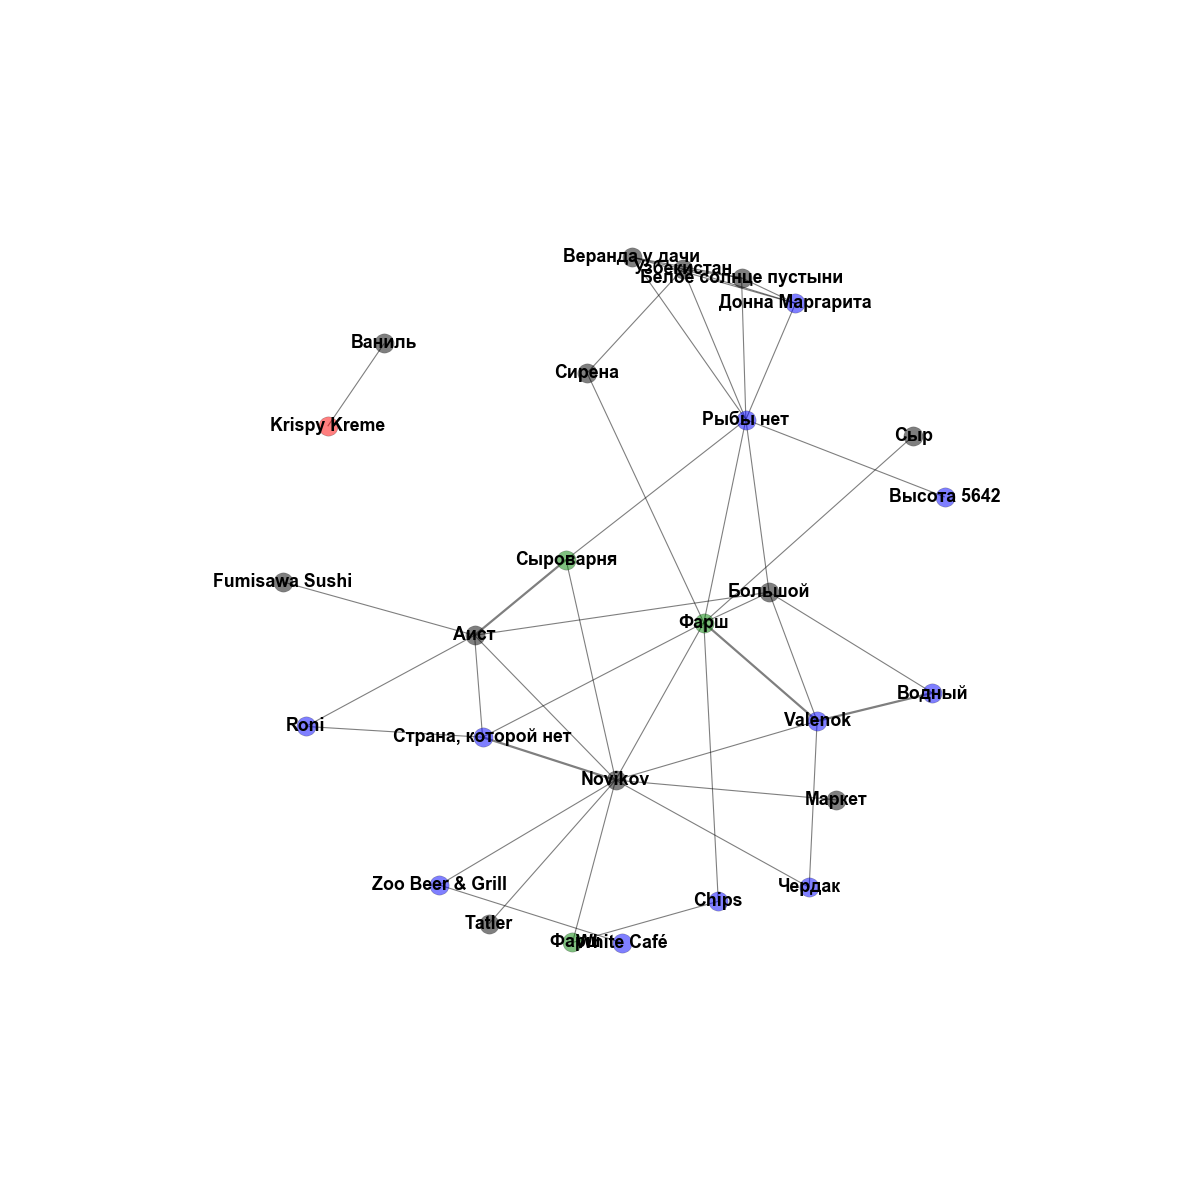

In [35]:
G2 = nx.Graph()
plt.figure(figsize=(15,15))
plt.axis('off')

for i in range(nov_rests_dists_vk.shape[0]):
    for j in range(nov_rests_dists_vk.shape[1]):
        if i > j:
            continue
        if nov_rests_dists_vk[i, j] > 0 and nov_rests_keys[i].strip() != nov_rests_keys[j].strip():
            G2.add_edge(nov_rests_keys[i], nov_rests_keys[j], weight=nov_rests_dists_vk[i, j])

pos=nx.spring_layout(G2, scale=0.1)
colors = {0: 'r', 1: 'g', 2: 'b', 3: 'k'}
for t in range(4):
    nodelist = [nov_rests_keys[i] for i in range(len(nov_rests_keys)) if t == y[i] and nov_rests_keys[i] in G2.nodes()]
    nx.draw_networkx_nodes(G2, pos, nodelist=nodelist, node_color=colors[t], alpha=0.5)

weights = [G2[u][v]['weight'] for u,v in G2.edges()]
nx.draw_networkx_edges(G2, pos, edgelist=G2.edges(), edge_color='k', alpha=0.5, width=weights)

nx.draw_networkx_labels(G2, pos, font_size=16, font_family='sans-serif', font_weight='bold')

plt.savefig("vk_man_part.png") # save as png
plt.show() # display